# Model Zoo

In this notebook you will see every kind of model in AstroPhot. Printed in each cell will also be the list of parameters which the model looks for while fitting. Many models have unique capabilities and features, this will be introduced here, though fully taking advantage of them will be dependent on your science case.

For a family tree of all the AstroPhot models see [this link](https://github.com/Autostronomy/AstroPhot/blob/main/media/AstroPhotModelOrgchart.png) 

Note, we will not be covering `Group_Model` here as that requires a dedicated discussion. See the dedicated notebook for that.

In [1]:
import astrophot as ap
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
basic_target = ap.image.Target_Image(np.zeros((100,100)), pixelscale = 1, zeropoint = 20)

## Sky Models

### Flat Sky Model

('sky',)
('log10(flux/arcsec^2)',)


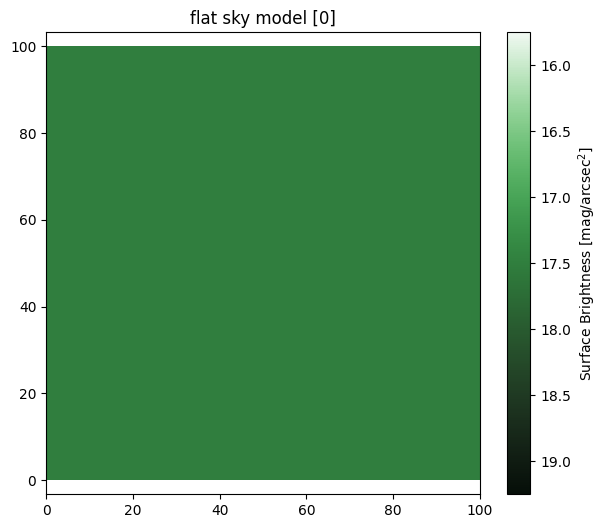

In [2]:
M = ap.models.AstroPhot_Model(
    model_type = "flat sky model", 
    parameters = {"center":[50,50], "sky": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(figsize = (7,6))
ap.plots.model_image(fig, ax, M)
ax.set_title(M.name)
plt.show()

### Plane Sky Model

('sky', 'delta')
('flux/arcsec^2', 'flux/arcsec')


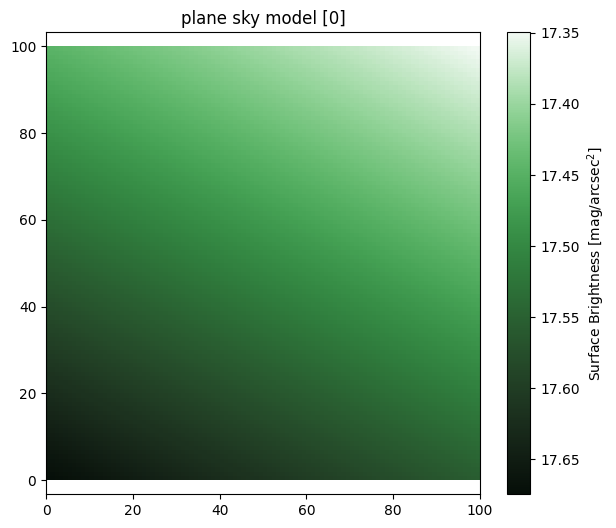

In [3]:
M = ap.models.AstroPhot_Model(
    model_type = "plane sky model", 
    parameters = {"center":[50,50], "sky": 10, "delta": [1e-2,2e-2]}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(figsize = (7,6))
ap.plots.model_image(fig, ax, M)
ax.set_title(M.name)
plt.show()

## Star Models

### PSF Star

Note that in this model you can define an arbitrary pixel map, for the sake of demonstration we build an extremely oversimplified mock diffraction spike model.

('center', 'flux')
('arcsec', 'log10(flux/arcsec^2)')


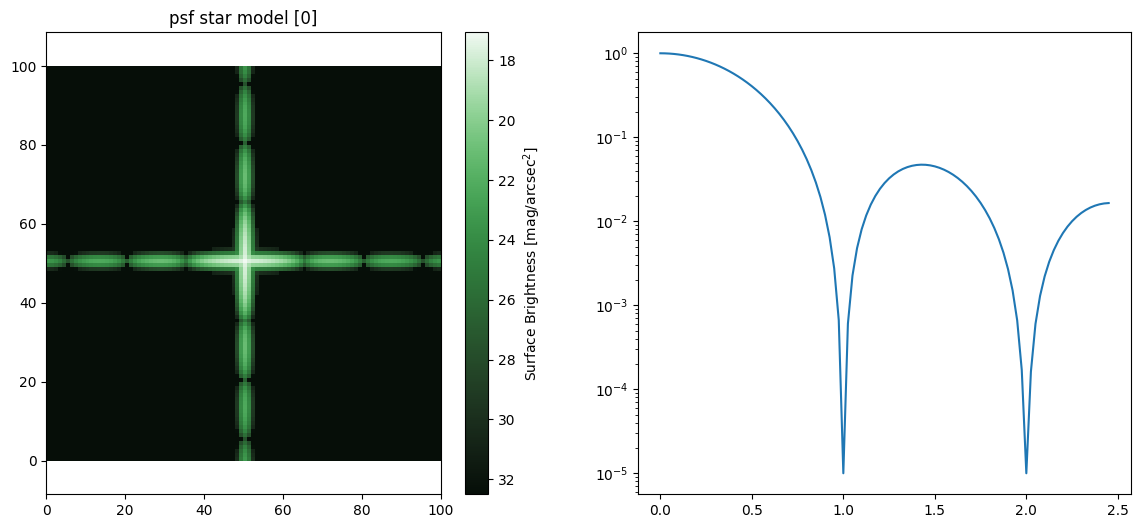

In [4]:
from scipy.special import sinc
xx, yy = np.meshgrid(np.linspace(-50,50,101), np.linspace(-50,50,101))
x = np.sqrt(xx**2 + yy**2)/15
PSF = np.zeros_like(x)+1e-6
wgt = np.array((0.0001,0.01,1.,0.01,0.0001))
PSF[48:53] += (sinc(x[48:53])**2) * wgt.reshape((-1,1))
PSF[:,48:53] += (sinc(x[:,48:53])**2) * wgt
PSF = ap.image.PSF_Image(data = PSF, pixelscale=basic_target.pixelscale)

M = ap.models.AstroPhot_Model(
    model_type = "psf star model", 
    target = basic_target, 
    parameters = {"center": [50.5,50.5], "flux": 1},
    psf = PSF,
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
x = np.linspace(0,49,99)/20
ax[1].plot(x, sinc(x)**2 + 1e-5)
ax[1].set_yscale("log")
ax[0].set_title(M.name)
plt.show()

### Gaussian Star

Never a great PSF model, but the Gaussian is simple. This makes it a good starting choice to get results before stepping up the complexity level.

('center', 'sigma', 'flux')
('arcsec', 'arcsec', 'log10(flux)')


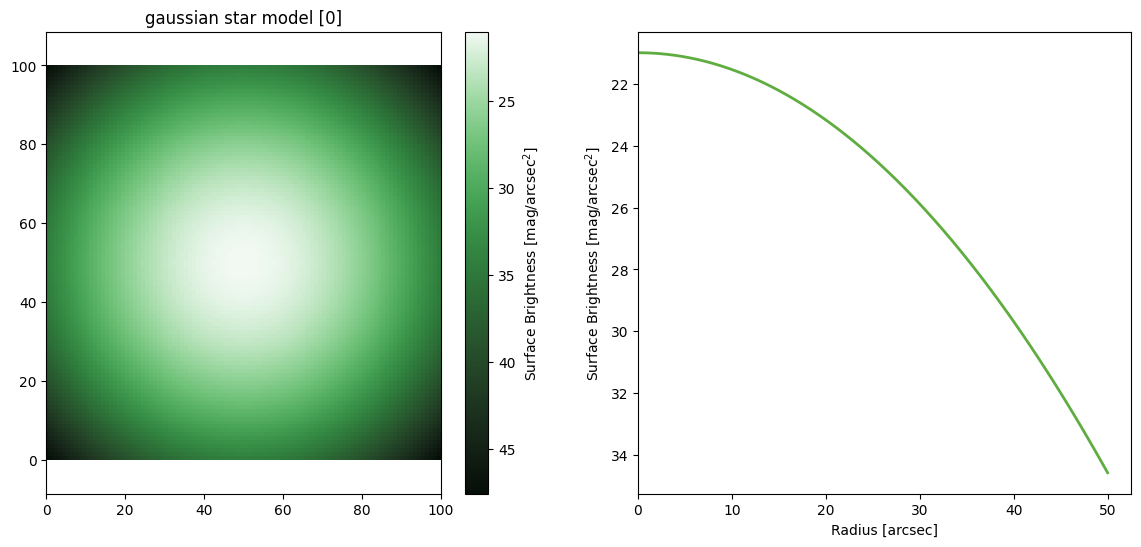

In [5]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian star model", 
    parameters = {"center":[50,50], "sigma": 10, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig, ax[1], M)
ax[0].set_title(M.name)
plt.show()

### Moffat Star

('center', 'n', 'Rd', 'I0')
('arcsec', 'none', 'arcsec', 'log10(flux/arcsec^2)')


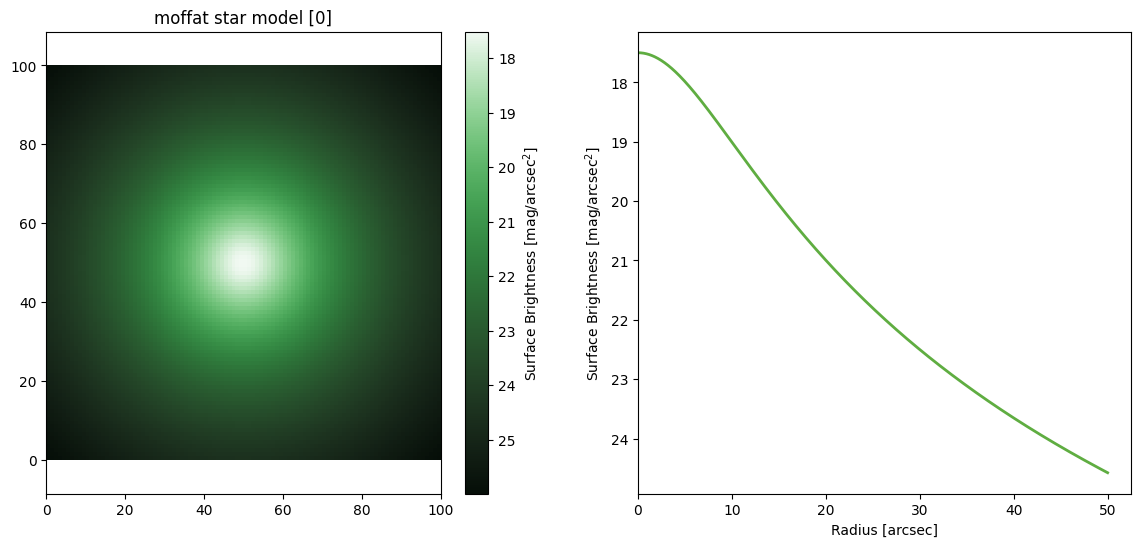

In [6]:
M = ap.models.AstroPhot_Model(
    model_type = "moffat star model", 
    parameters = {"center":[50,50], "n": 2., "Rd": 10., "I0": 1.}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig, ax[1], M)
ax[0].set_title(M.name)
plt.show()

### Airy disk

('center', 'I0', 'aRL')
('arcsec', 'log10(flux/arcsec^2)', 'a/(R lambda)')


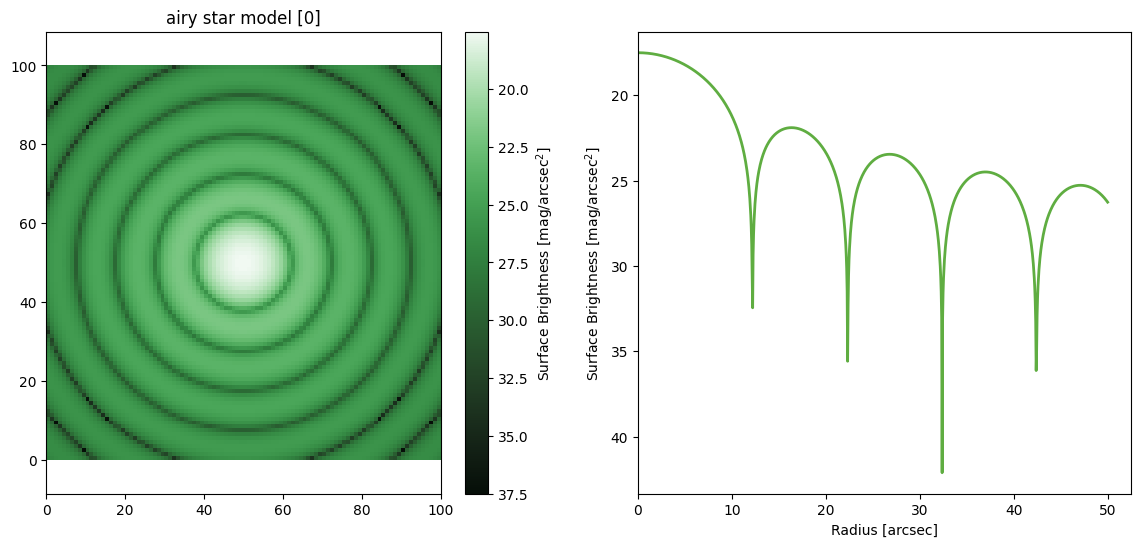

In [46]:
M = ap.models.AstroPhot_Model(
    model_type = "airy star model", 
    parameters = {"center":[50,50], "I0": 1., "aRL": 1./20}, 
    target = basic_target,
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig, ax[1], M)
ax[0].set_title(M.name)
plt.show()

### Zernike Polynomial star

('center', 'Anm')
('arcsec', 'flux/arcsec^2')


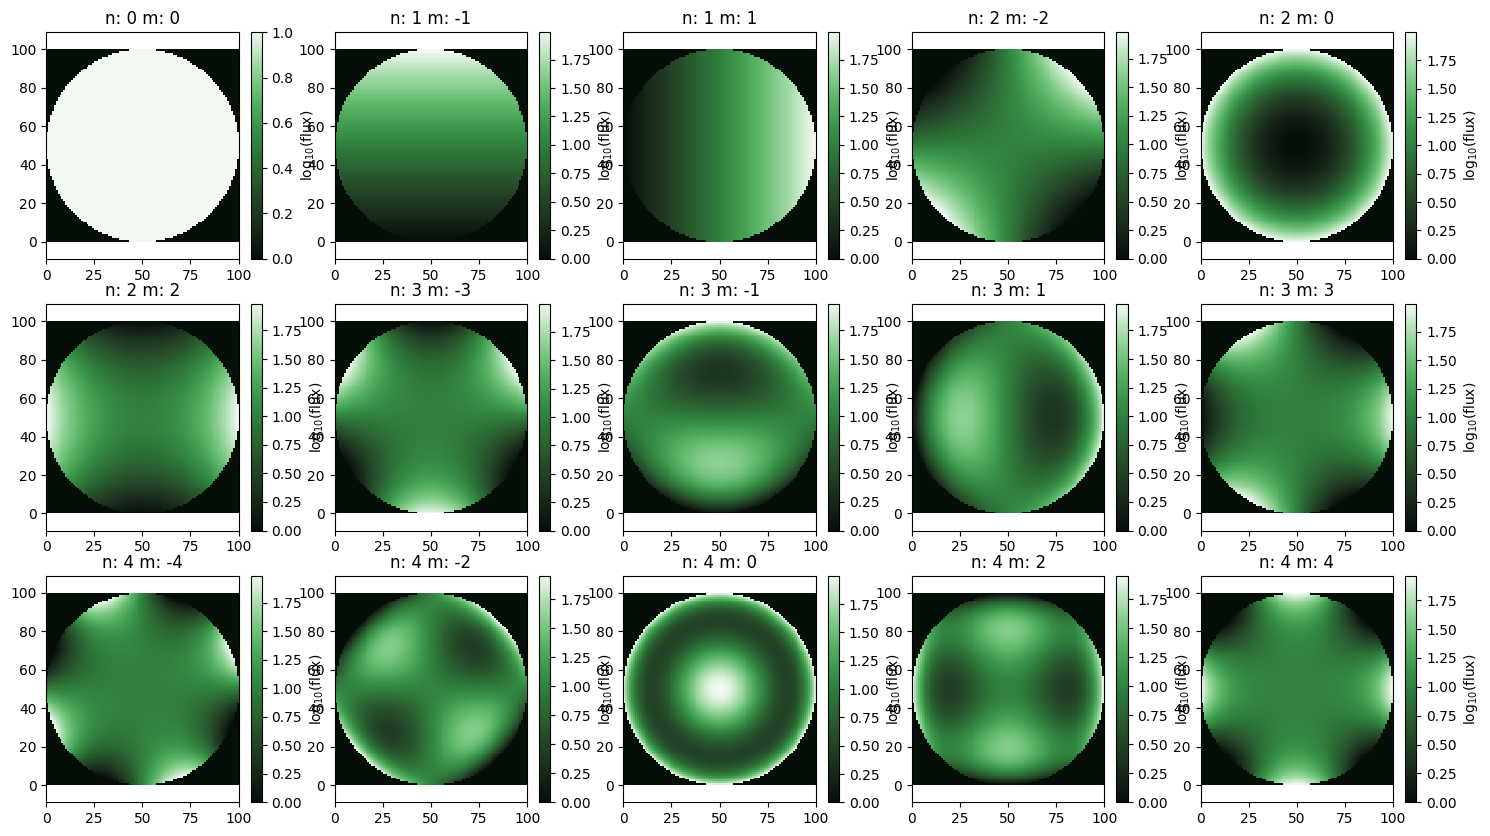

In [8]:
super_basic_target = ap.image.Target_Image(np.zeros((100,100)), pixelscale = 1)
M = ap.models.AstroPhot_Model(
    model_type = "zernike star model", 
    parameters = {"center":[50,50]}, 
    order_n = 4, 
    integrate_mode = "none", 
    target = super_basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, axarr = plt.subplots(3,5, figsize = (18, 10))
for i, ax in enumerate(axarr.flatten()):
    Anm = torch.zeros_like(M["Anm"].value)
    Anm[0] = 1.
    Anm[i] = 1.
    M["Anm"].value = Anm
    ax.set_title(f"n: {M.nm_list[i][0]} m: {M.nm_list[i][1]}")
    ap.plots.model_image(fig, ax, M, norm = None)
plt.show()

# Galaxy Models

### Spline Galaxy Model

This model has a radial surface brightness profile which can take on any function (that can be represented as a spline). This is somewhat like elliptical isophote fitting, though it is more precise in its definition of the SB model.

('center', 'q', 'PA', 'I(R)')
('arcsec', 'b/a', 'radians', 'log10(flux/arcsec^2)')


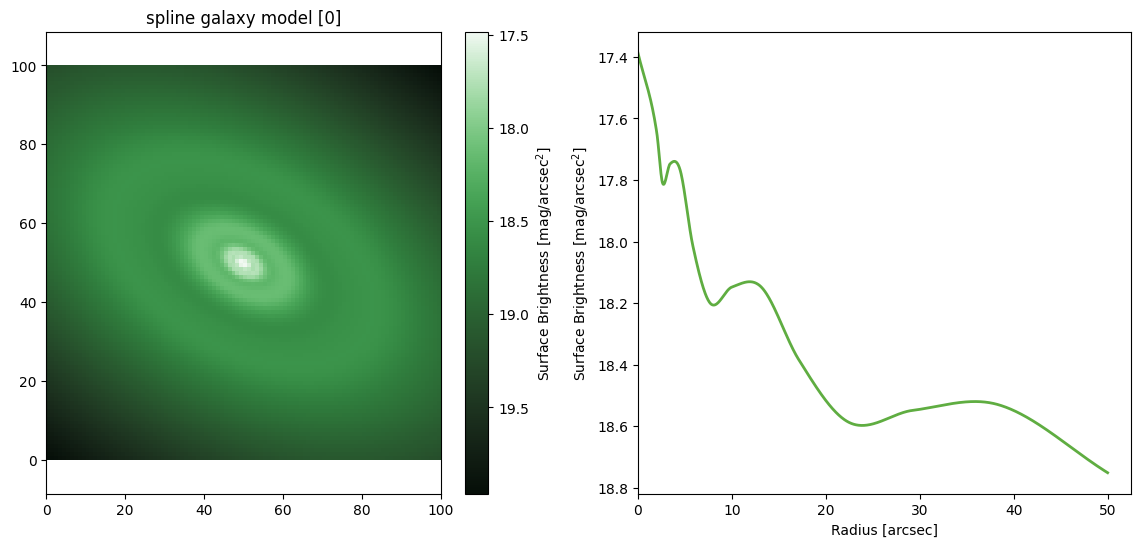

In [9]:
# Here we make an arbitrary spline profile out of a sine wave and a line
x = np.linspace(0,10,14)
spline_profile = np.sin(x*2+2)/20 + 1 - x/20
# Here we write down some corresponding radii for the points in the non-parametric profile. AstroPhot will make 
# radii to match an input profile, but it is generally better to manually provide values so you have some control 
# over their placement. Just note that it is assumed the first point will be at R = 0.
NP_prof = [0] + list(np.logspace(np.log10(2),np.log10(50),13))

M = ap.models.AstroPhot_Model(
    model_type = "spline galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic Galaxy Model

('center', 'q', 'PA', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'none', 'arcsec', 'log10(flux/arcsec^2)')


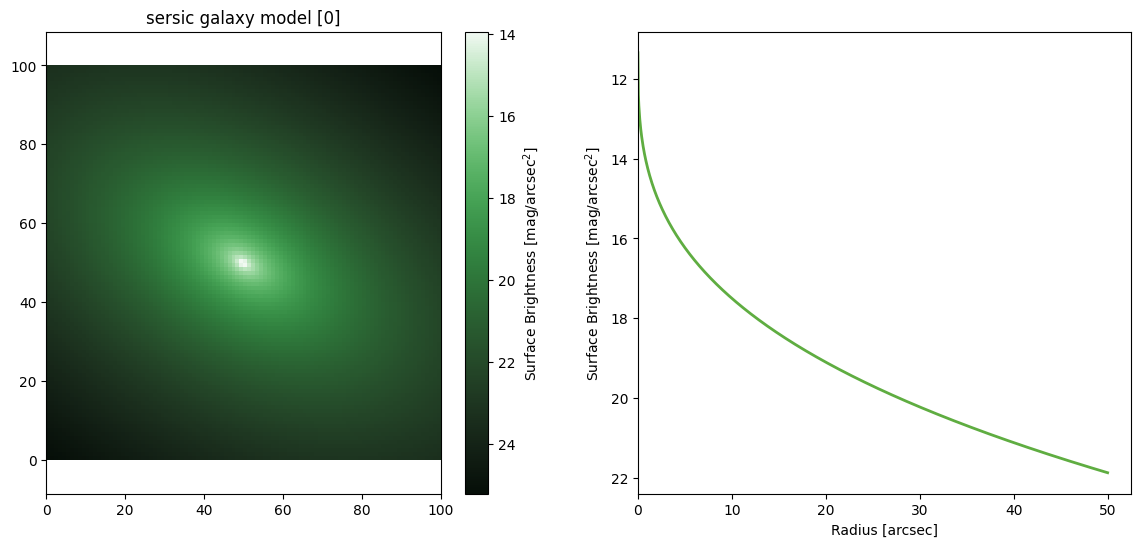

In [10]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential Galaxy Model

('center', 'q', 'PA', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux/arcsec^2)')


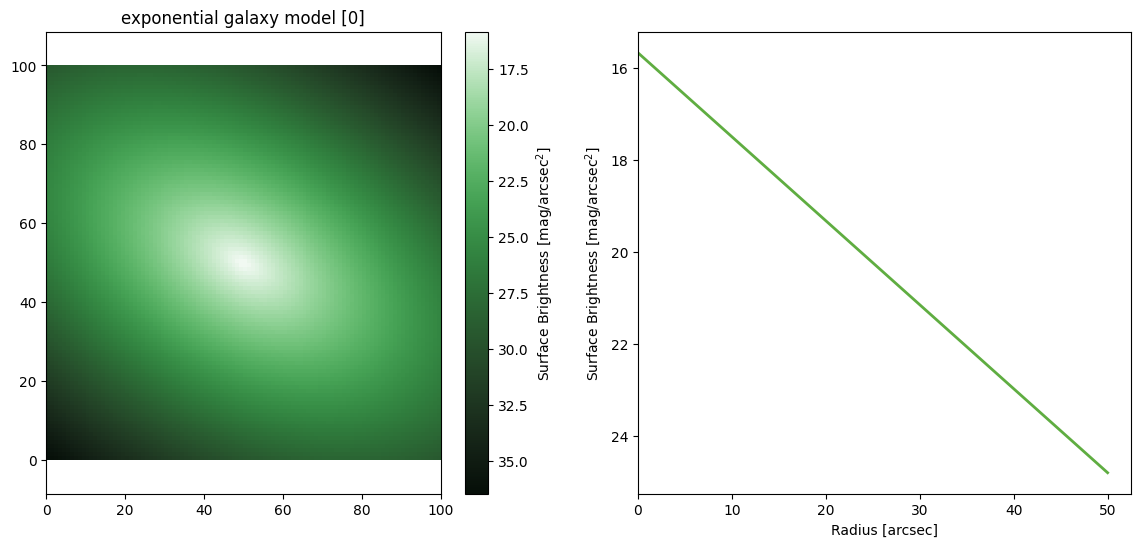

In [11]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian Galaxy Model

('center', 'q', 'PA', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux)')


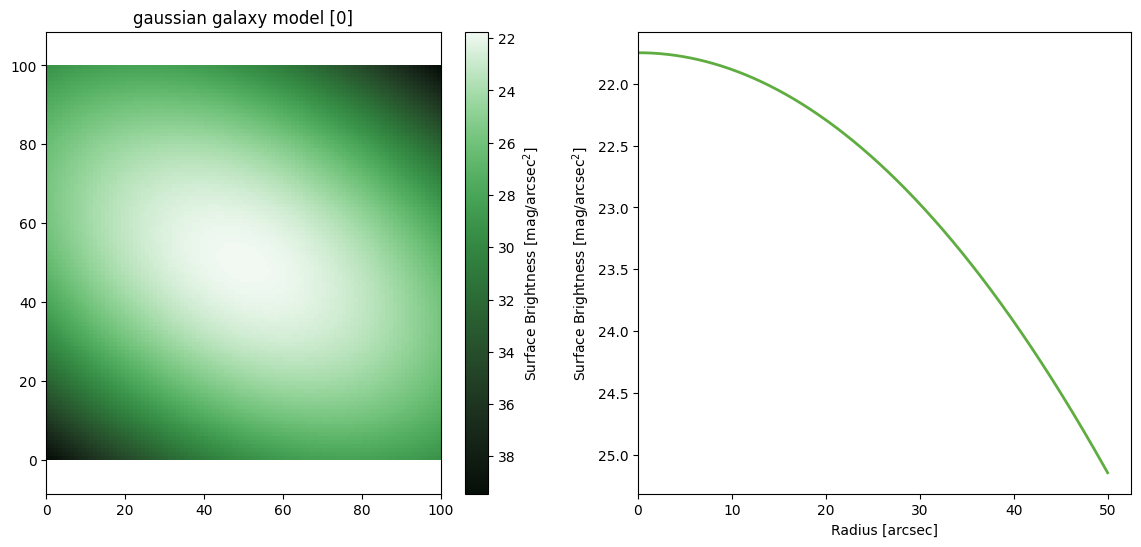

In [12]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "sigma": 20, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Nuker Galaxy Model

('center', 'q', 'PA', 'Rb', 'Ib', 'alpha', 'beta', 'gamma')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux/arcsec^2)', 'none', 'none', 'none')


/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


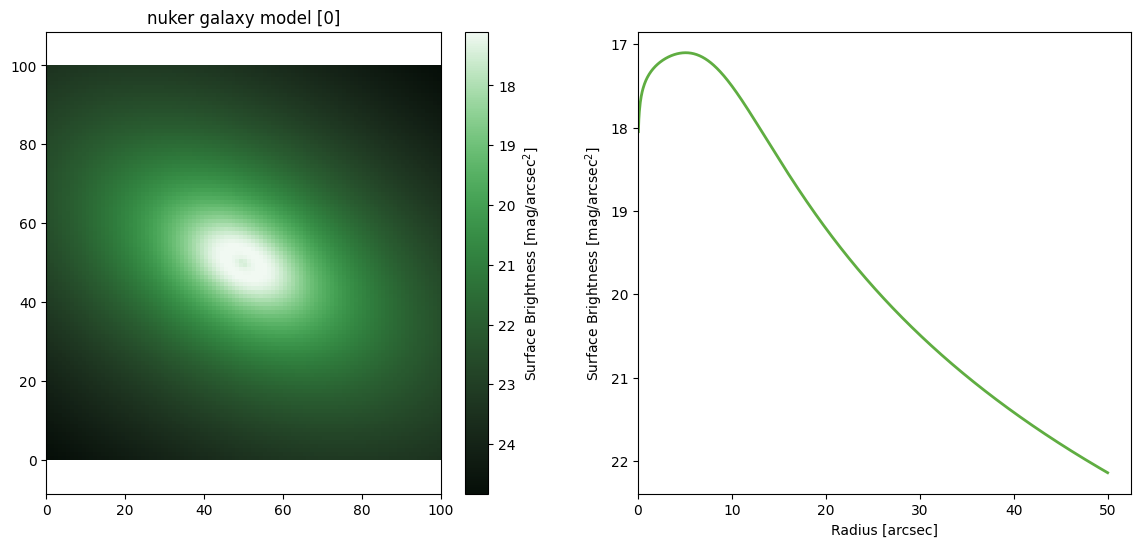

In [13]:
M = ap.models.AstroPhot_Model(
    model_type = "nuker galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "Rb": 10., "Ib": 1., "alpha": 4., "beta": 3., "gamma": -0.2}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Edge on model

Currently there is only one dedicared edge on model, the self gravitating isothermal disk from van der Kruit & Searle 1981. If you know of another common edge on model, feel free to let us know and we can add it in!

('center', 'PA', 'I0', 'hs', 'rs')
('arcsec', 'rad', 'log10(flux/arcsec^2)', 'arcsec', 'arcsec')


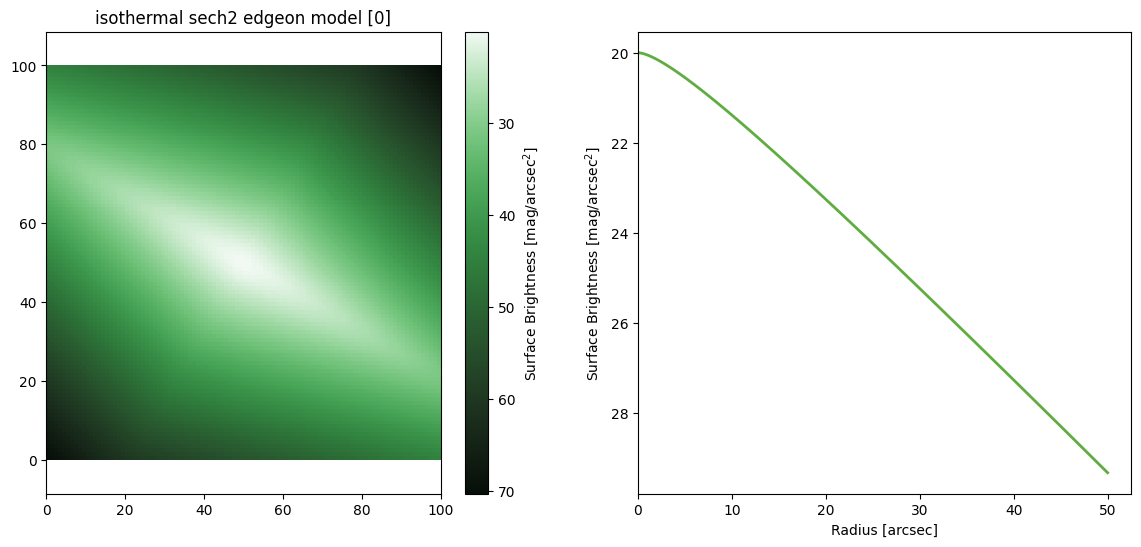

In [14]:
M = ap.models.AstroPhot_Model(
    model_type = "isothermal sech2 edgeon model", 
    parameters = {"center": [50,50], "PA": 60*np.pi/180, "I0": 0., "hs": 3., "rs": 5.}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Super Ellipse Models

A super ellipse is a regular ellipse, except the radius metric changes from R = sqrt(x^2 + y^2) to the more general: R = (x^C + y^C)^1/C. The parameter C = 2 for a regular ellipse, for 0<C<2 the shape becomes more "disky" and for C > 2 the shape becomes more "boxy." In AstroPhot we use the parameter C0 = C-2 for simplicity.

### Spline SuperEllipse

('center', 'q', 'PA', 'C0', 'I(R)')
('arcsec', 'b/a', 'radians', 'C-2', 'log10(flux/arcsec^2)')


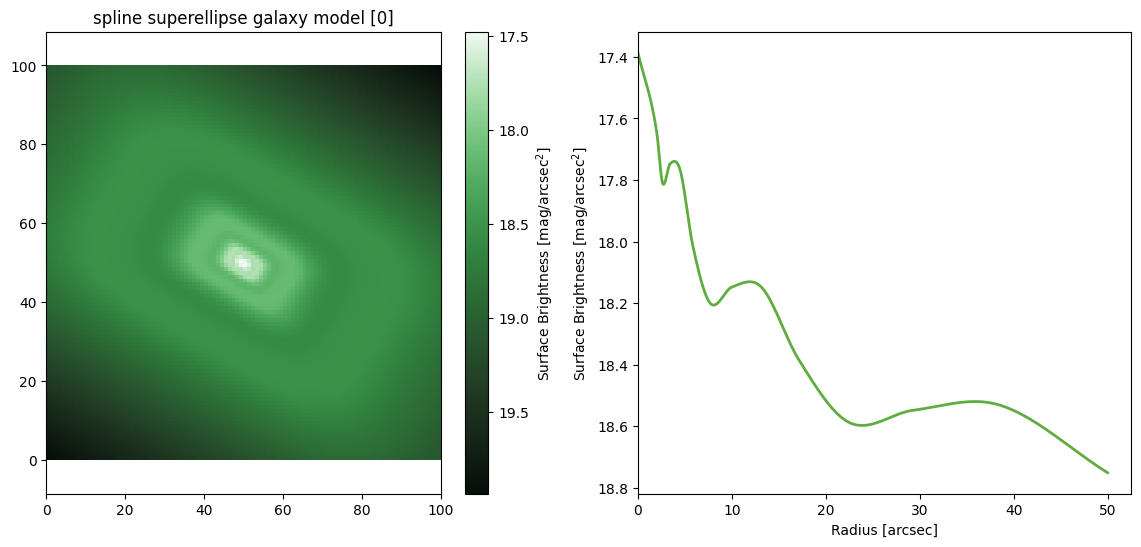

In [15]:
M = ap.models.AstroPhot_Model(
    model_type = "spline superellipse galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "C0": 2, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic SuperEllipse

('center', 'q', 'PA', 'C0', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'C-2', 'none', 'arcsec', 'log10(flux/arcsec^2)')


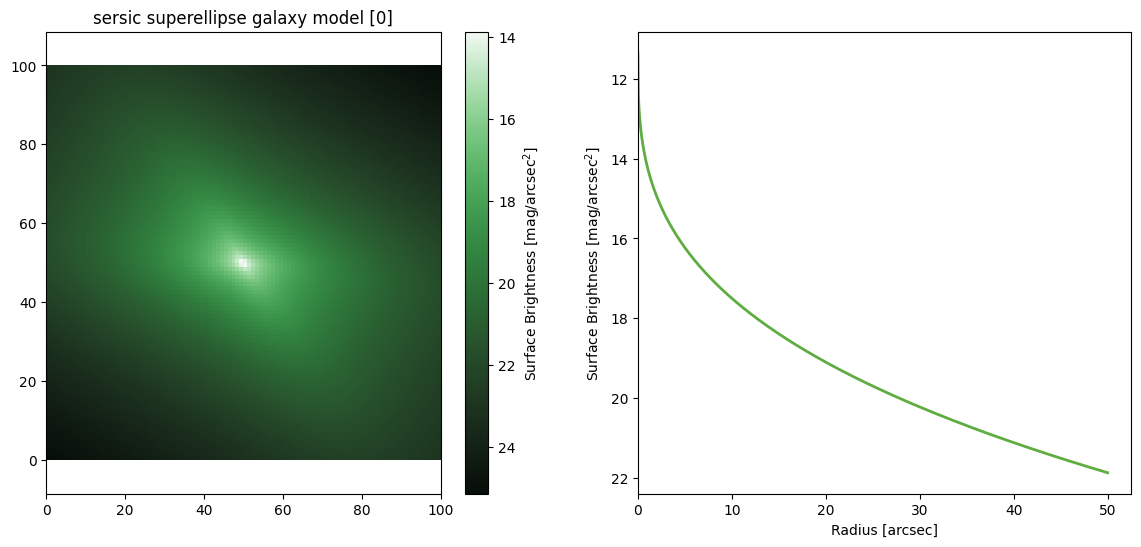

In [16]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic superellipse galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "C0": 2, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential SuperEllipse

('center', 'q', 'PA', 'C0', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'C-2', 'arcsec', 'log10(flux/arcsec^2)')


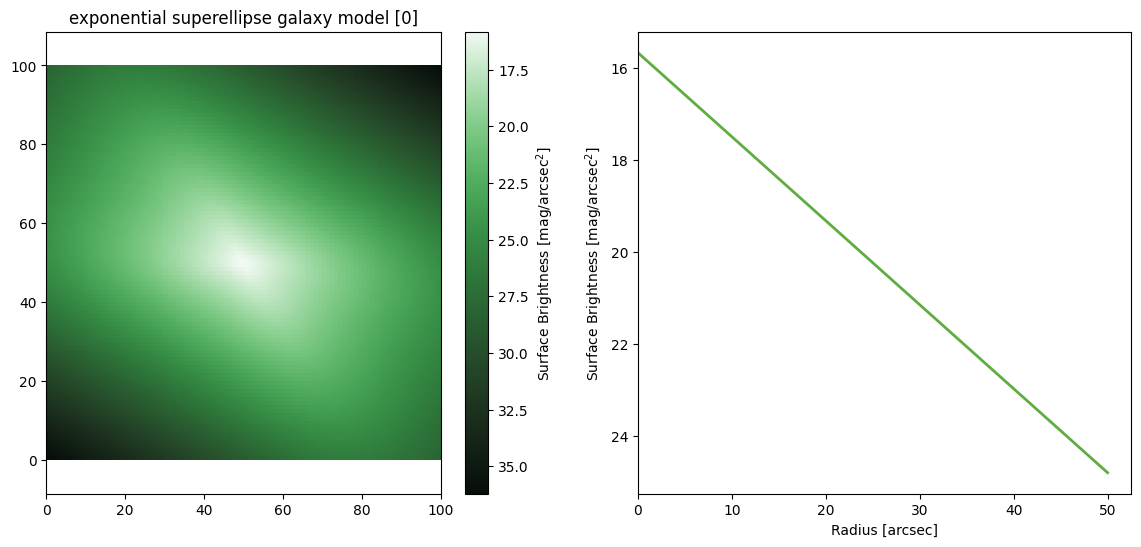

In [17]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential superellipse galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "C0": 2, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian SuperEllipse

('center', 'q', 'PA', 'C0', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'C-2', 'arcsec', 'log10(flux)')


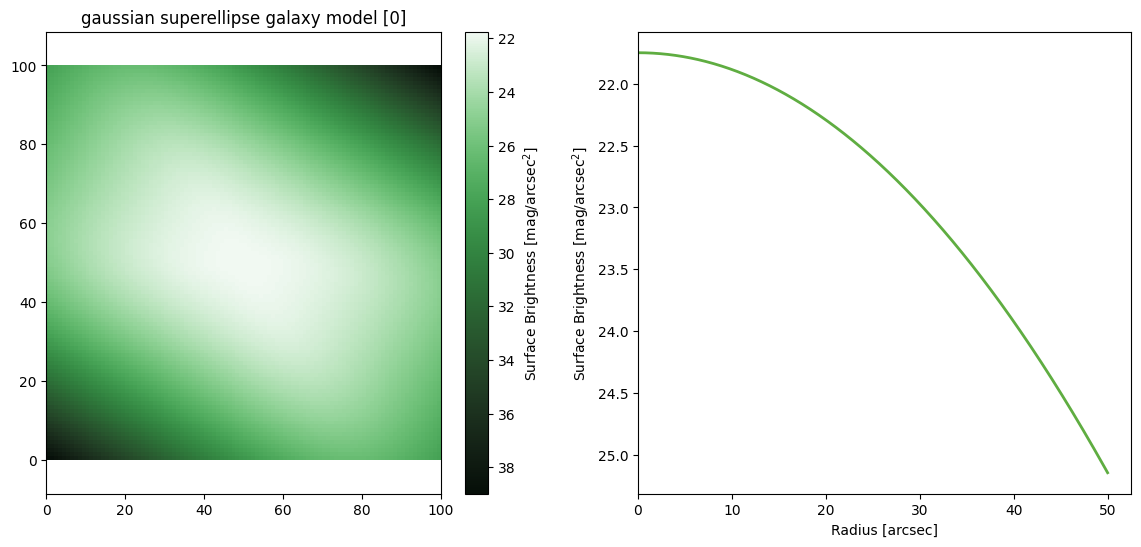

In [18]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian superellipse galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "C0": 2, "sigma": 20, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Nuker SuperEllipse

('center', 'q', 'PA', 'C0', 'Rb', 'Ib', 'alpha', 'beta', 'gamma')
('arcsec', 'b/a', 'radians', 'C-2', 'arcsec', 'log10(flux/arcsec^2)', 'none', 'none', 'none')


/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


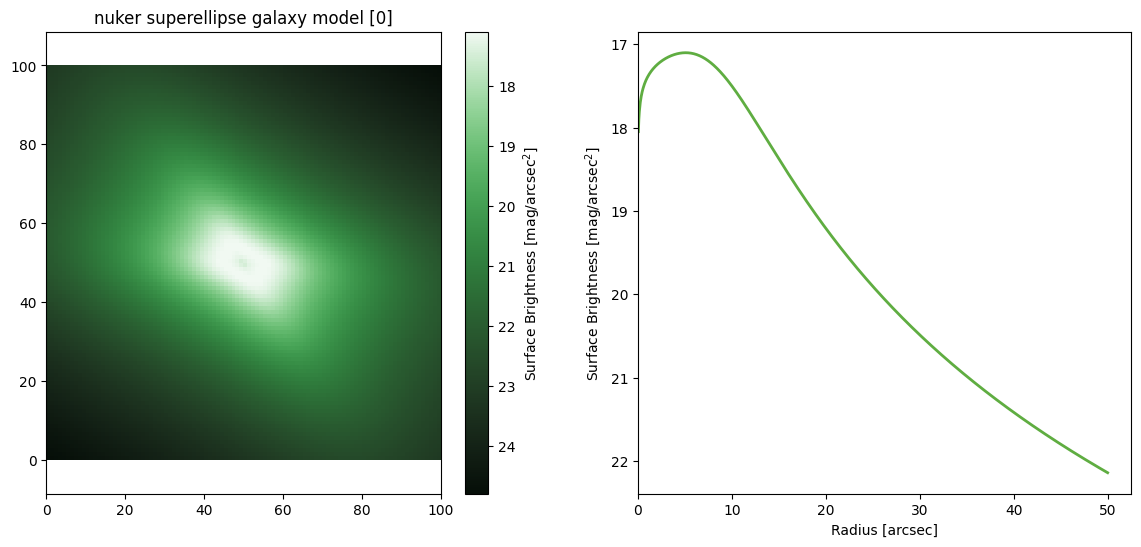

In [19]:
M = ap.models.AstroPhot_Model(
    model_type = "nuker superellipse galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "C0": 2, "Rb": 10., "Ib": 1., "alpha": 4., "beta": 3., "gamma": -0.2}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Fourier Ellipse Models

A Fourier ellipse is a scaling on the radius values as a function of theta. It takes the form: $R' = R * exp(\sum_m am*cos(m*theta + phim))$, where am and phim are the parameters which describe the Fourier perturbations. Using the "modes" argument as a tuple, users can select which Fourier modes are used. As a rough intuition: mode 1 acts like a shift of the model; mode 2 acts like ellipticity; mode 3 makes a lopsided model (triangular in the extreme); and mode 4 makes peanut/diamond perturbations. 

### Spline Fourier

('center', 'q', 'PA', 'am', 'phim', 'I(R)')
('arcsec', 'b/a', 'radians', 'none', 'radians', 'log10(flux/arcsec^2)')


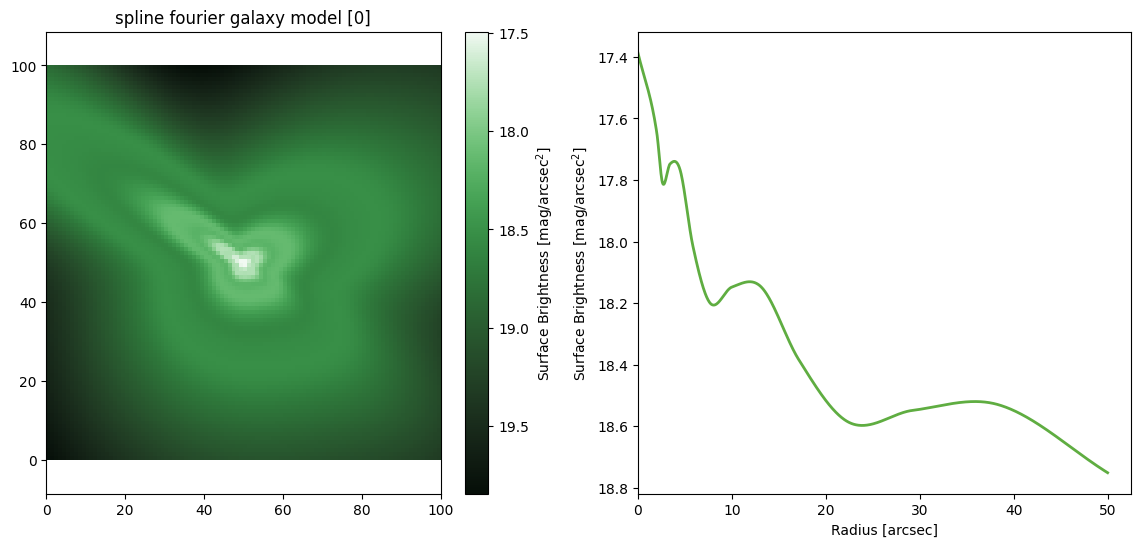

In [20]:
fourier_am = np.array([0.1, 0.3, -0.2])
fourier_phim = np.array([10*np.pi/180, 0, 40*np.pi/180])
M = ap.models.AstroPhot_Model(
    model_type = "spline fourier galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "am": fourier_am, "phim": fourier_phim, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic Fourier

('center', 'q', 'PA', 'am', 'phim', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'none', 'radians', 'none', 'arcsec', 'log10(flux/arcsec^2)')


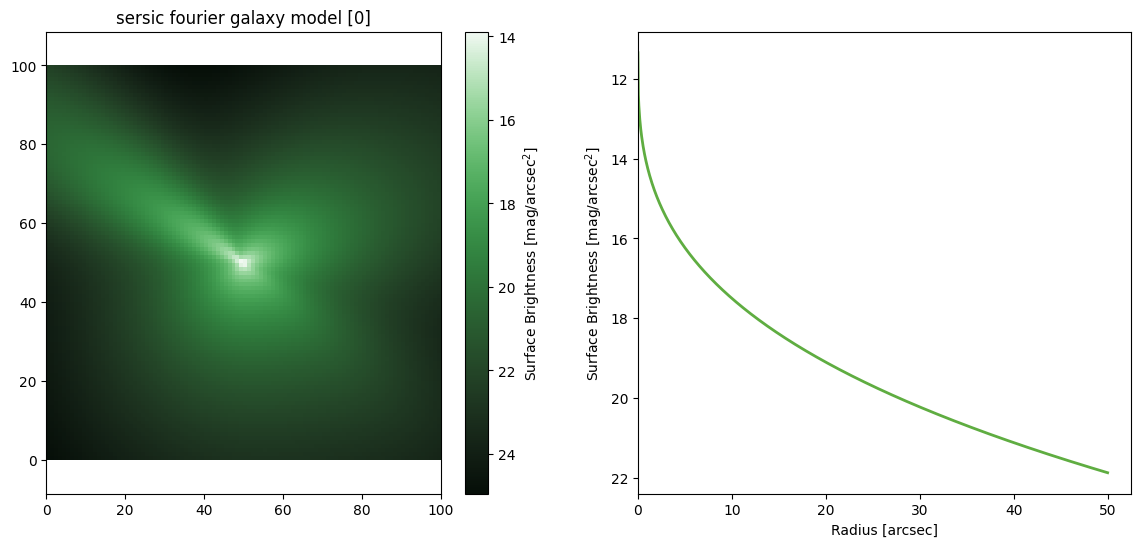

In [21]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic fourier galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "am": fourier_am, "phim": fourier_phim, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential Fourier

('center', 'q', 'PA', 'am', 'phim', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'none', 'radians', 'arcsec', 'log10(flux/arcsec^2)')


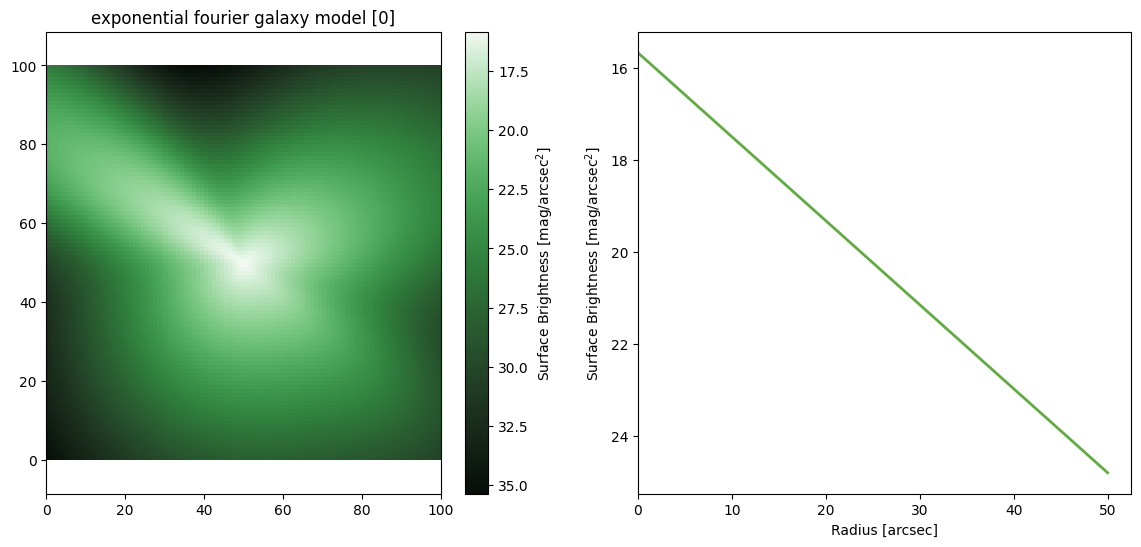

In [22]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential fourier galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "am": fourier_am, "phim": fourier_phim, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian Fourier

('center', 'q', 'PA', 'am', 'phim', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'none', 'radians', 'arcsec', 'log10(flux)')


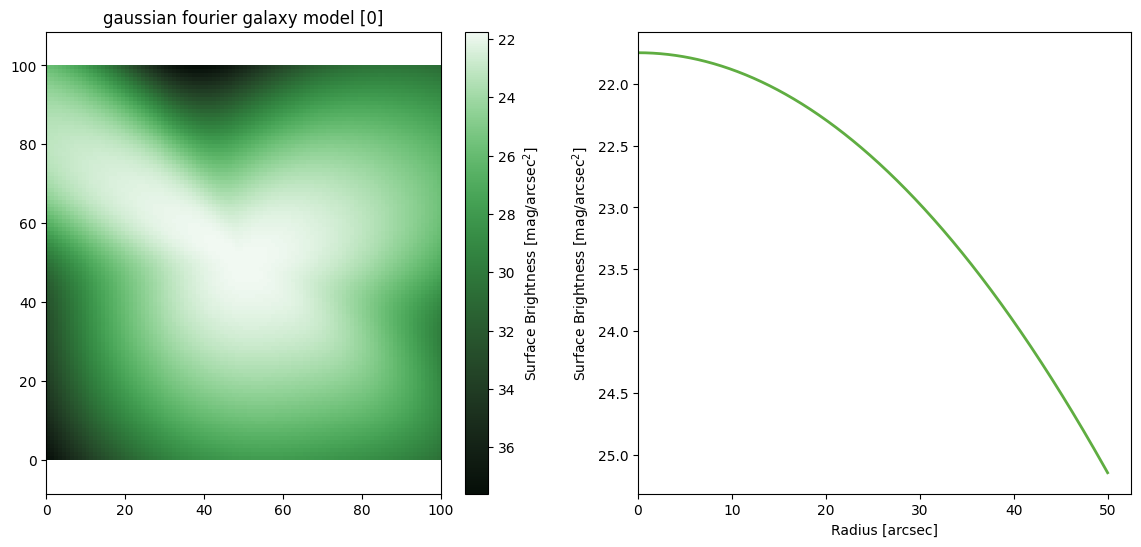

In [23]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian fourier galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "am": fourier_am, "phim": fourier_phim, "sigma": 20, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Nuker Fourier

('center', 'q', 'PA', 'am', 'phim', 'Rb', 'Ib', 'alpha', 'beta', 'gamma')
('arcsec', 'b/a', 'radians', 'none', 'radians', 'arcsec', 'log10(flux/arcsec^2)', 'none', 'none', 'none')


/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


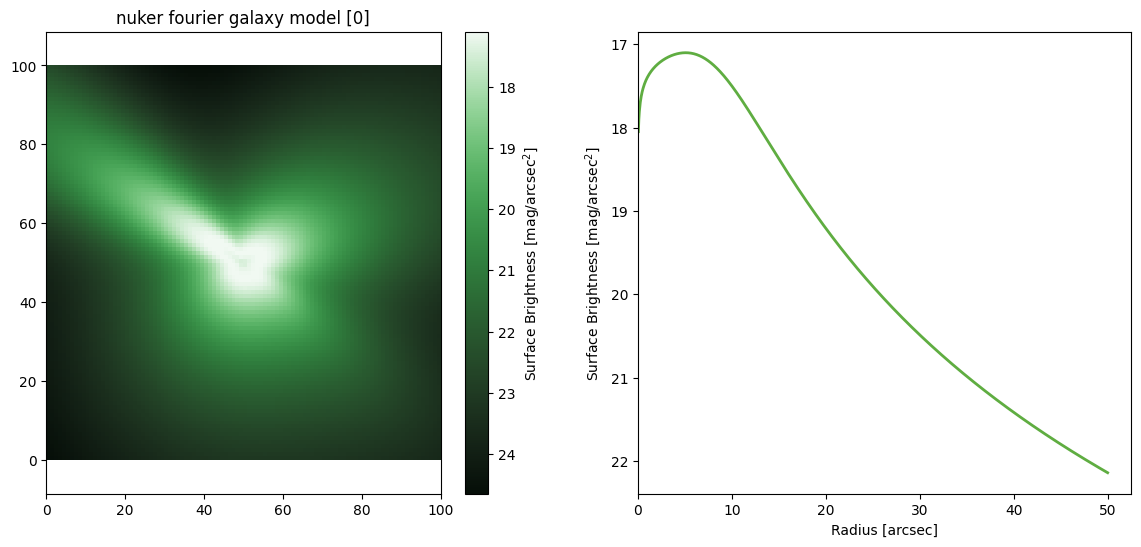

In [24]:
M = ap.models.AstroPhot_Model(
    model_type = "nuker fourier galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "am": fourier_am, "phim": fourier_phim, "Rb": 10., "Ib": 1., "alpha": 4., "beta": 3., "gamma": -0.2}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Warp Model

A warp model performs a radially varying coordinate transform. Essentially instead of applying a rotation matrix **Rot** on all coordinates X,Y we instead construct a unique rotation matrix for each coordinate pair **Rot(R)** where $R = \sqrt(X^2 + Y^2)$. We also apply a radially dependent axis ratio **q(R)** to all the coordinates:

$R = \sqrt(X^2 + Y^2)$

$X, Y = Rotate(X, Y, PA(R))$

$Y = Y / q(R)$

The net effect is a radially varying PA and axis ratio which allows the model to represent spiral arms, bulges, or other features that change the apparent shape of a galaxy in a radially varying way.

### Spline Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'I(R)')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'log10(flux/arcsec^2)')


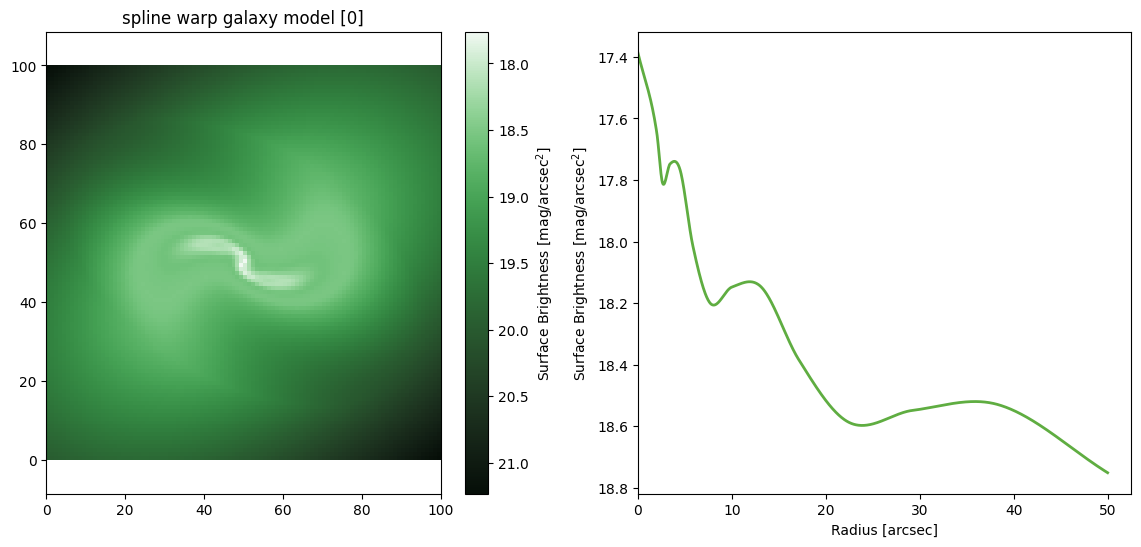

In [25]:
warp_q = np.linspace(0.1,0.4,14)
warp_pa = np.linspace(0,np.pi-0.2,14)
M = ap.models.AstroPhot_Model(
    model_type = "spline warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'none', 'arcsec', 'log10(flux/arcsec^2)')


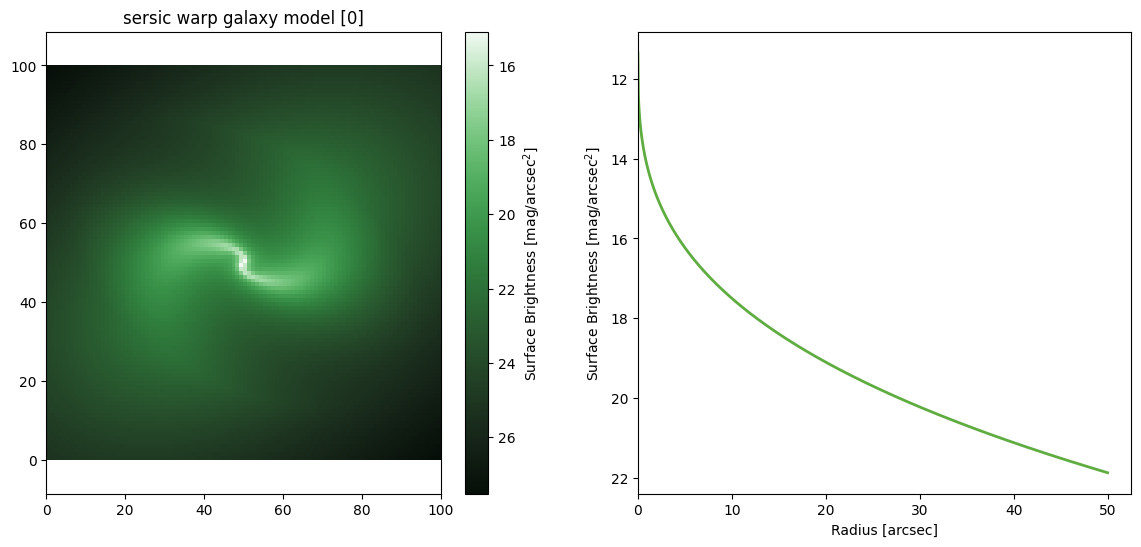

In [26]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'arcsec', 'log10(flux/arcsec^2)')


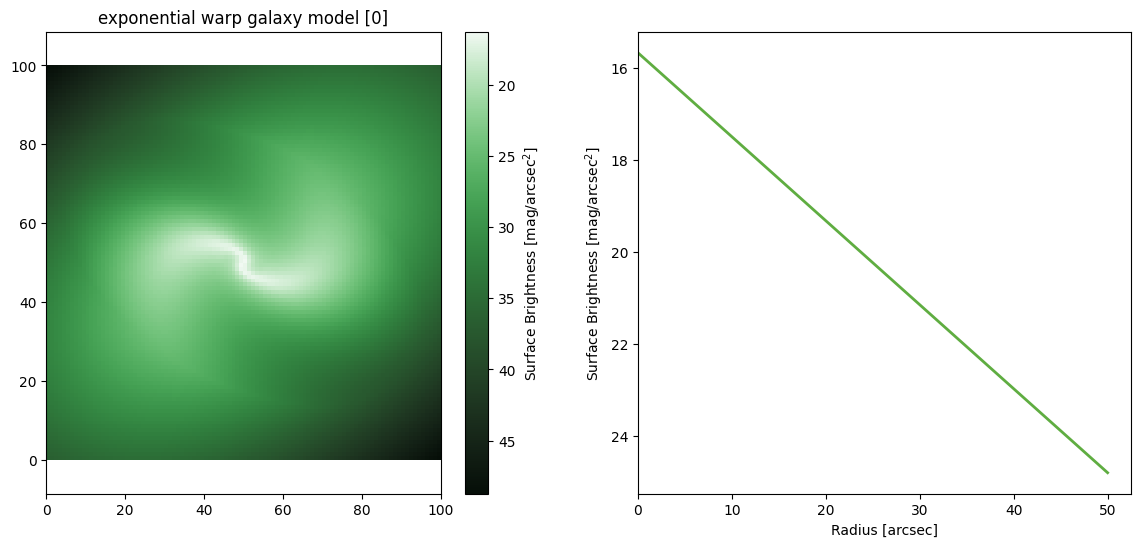

In [27]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'arcsec', 'log10(flux)')


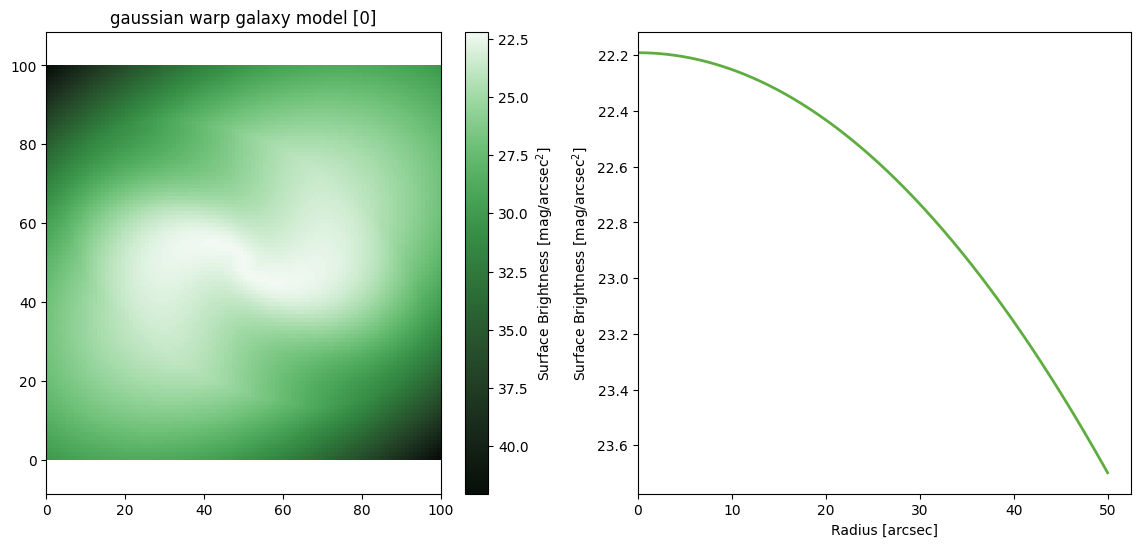

In [28]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "sigma": 30, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Nuker Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'Rb', 'Ib', 'alpha', 'beta', 'gamma')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'arcsec', 'log10(flux/arcsec^2)', 'none', 'none', 'none')


/home/connor/Programming/AstroPhot/astrophot/utils/conversions/units.py:16: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint + 2.5 * np.log10(pixel_area)


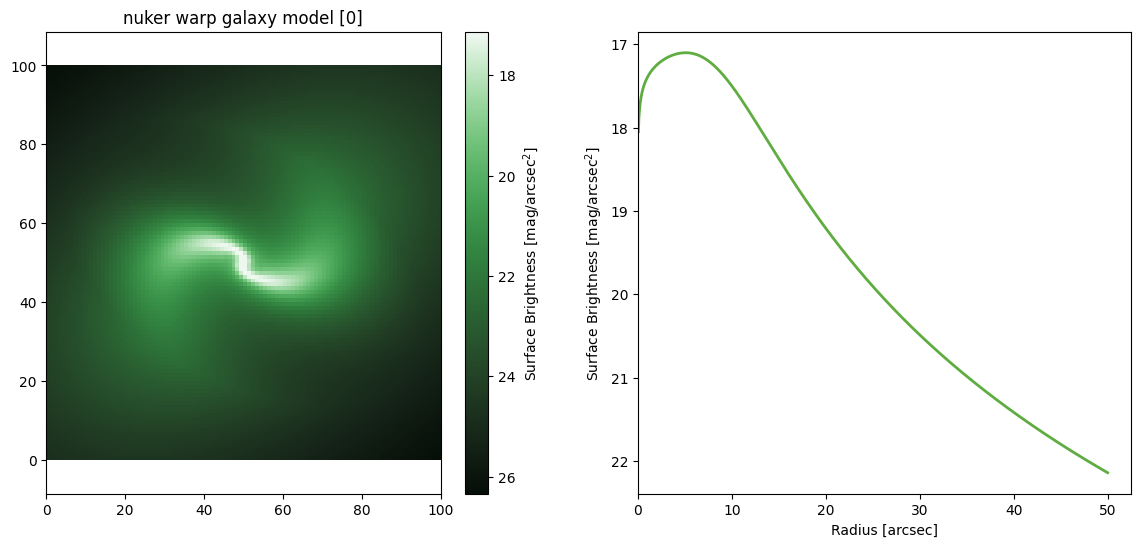

In [29]:
M = ap.models.AstroPhot_Model(
    model_type = "nuker warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "Rb": 10., "Ib": 1., "alpha": 4., "beta": 3., "gamma": -0.2}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Ray Model

A ray model allows the user to break the galaxy up into regions that can be fit separately. There are two basic kinds of ray model: symmetric and asymetric. A symmetric ray model (symmetric_rays = True) assumes 180 degree symmetry of the galaxy and so each ray is reflected through the center. This means that essentially the major axes and the minor axes are being fit separately. For an asymmetric ray model (symmetric_rays = False) each ray is it's own profile to be fit separately. 

In a ray model there is a smooth boundary between the rays. This smoothness is acomplished by applying a $(\cos(r*theta)+1)/2$ weight to each profile, where r is dependent on the number of rays and theta is shifted to center on each ray in turn. The exact cosine weighting is dependent on if the rays are symmetric and if there is an even or odd number of rays. 

### Spline Ray

('center', 'q', 'PA', 'I(R)')
('arcsec', 'b/a', 'radians', 'log10(flux/arcsec^2)')


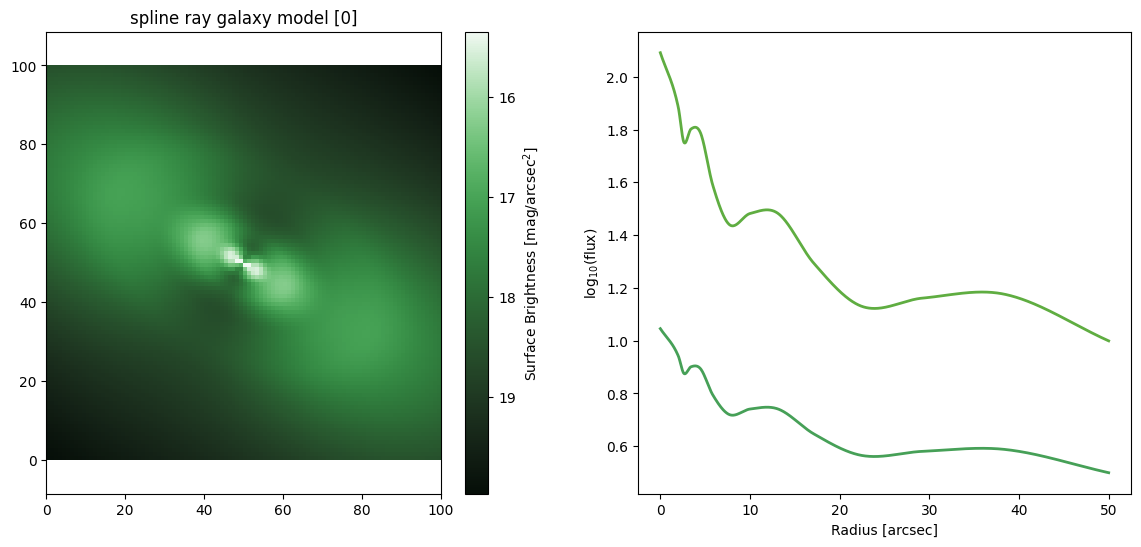

In [30]:
M = ap.models.AstroPhot_Model(
    model_type = "spline ray galaxy model", 
    symmetric_rays = True, 
    rays = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "I(R)": {"value": np.array([spline_profile*2, spline_profile]), "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.ray_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic Ray

('center', 'q', 'PA', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'none', 'arcsec', 'log10(flux/arcsec^2)')


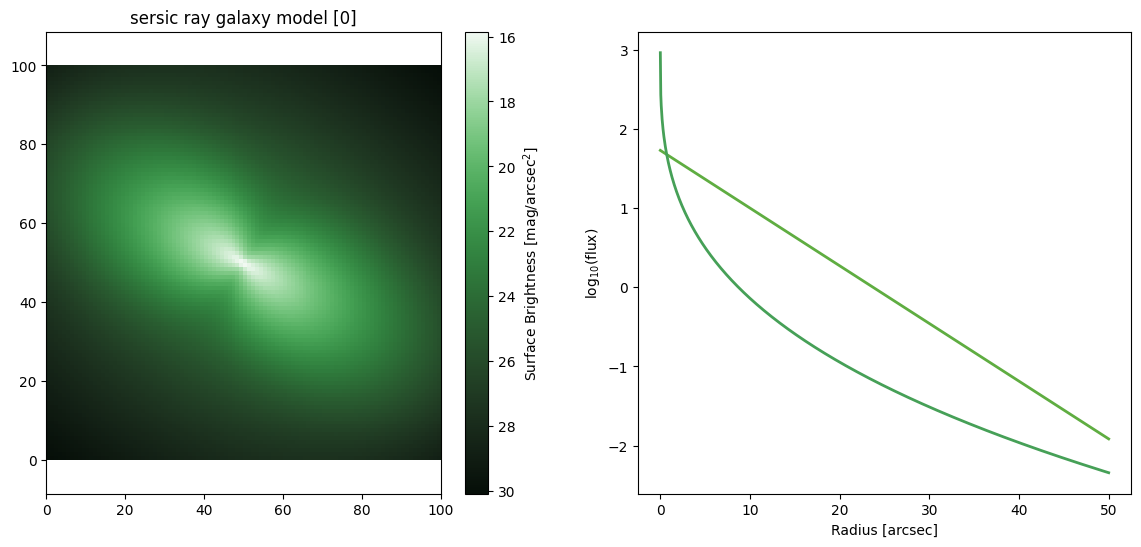

In [31]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic ray galaxy model", 
    symmetric_rays = True, 
    rays = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "n": [1,3], "Re": [10,5],"Ie": [1,0.5]}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.ray_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential Ray

('center', 'q', 'PA', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux/arcsec^2)')


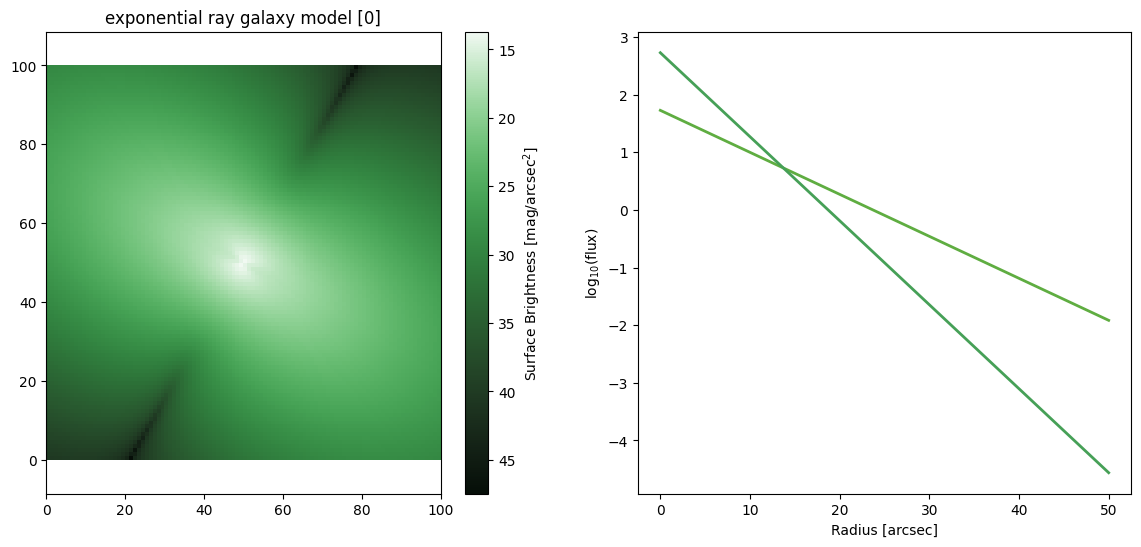

In [32]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential ray galaxy model", 
    symmetric_rays = True, 
    rays = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "Re": [10,5], "Ie": [1,2]}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.ray_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian Ray

('center', 'q', 'PA', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux)')


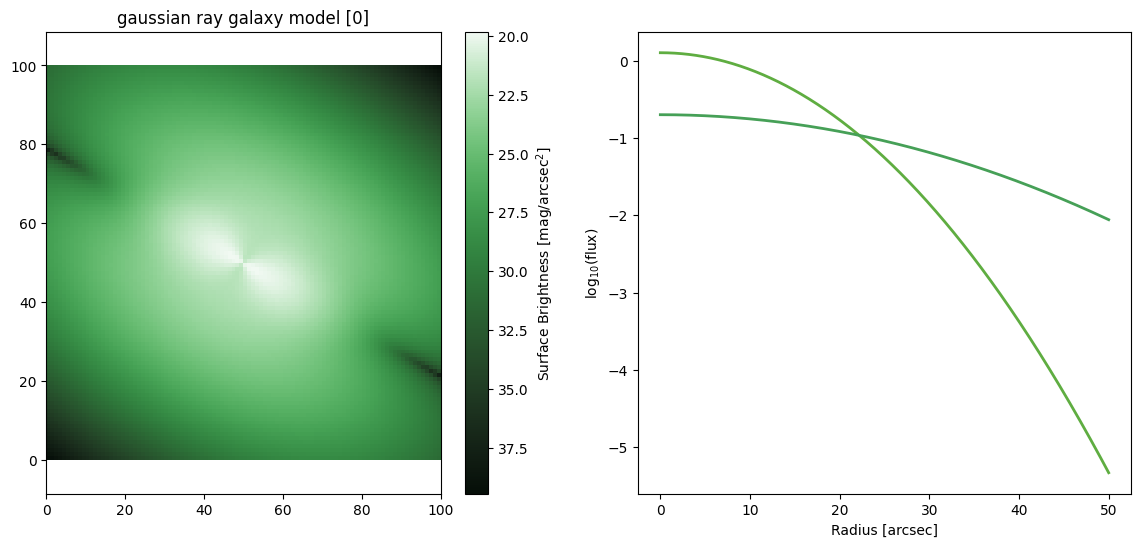

In [33]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian ray galaxy model", 
    symmetric_rays = True, 
    rays = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "sigma": [10,20], "flux": [1.5,1.]}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.ray_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Nuker Ray

('center', 'q', 'PA', 'Rb', 'Ib', 'alpha', 'beta', 'gamma')
('arcsec', 'b/a', 'radians', 'arcsec', 'log10(flux/arcsec^2)', 'none', 'none', 'none')


/home/connor/Programming/AstroPhot/astrophot/plots/profile.py:196: RuntimeWarning: divide by zero encountered in log10
  np.log10(model.iradial_model(r, xx).detach().cpu().numpy()),


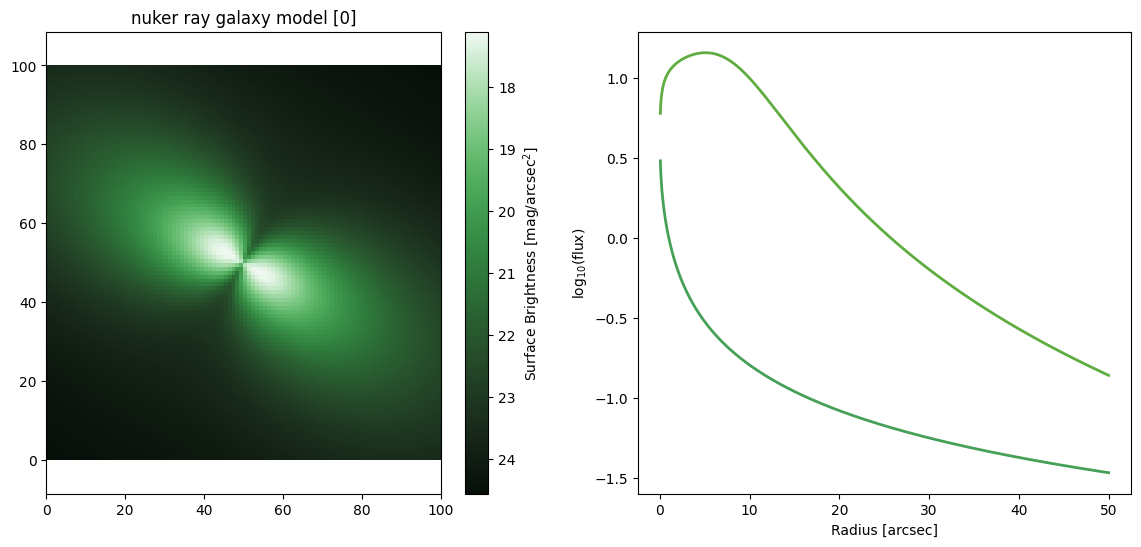

In [34]:
M = ap.models.AstroPhot_Model(
    model_type = "nuker ray galaxy model", 
    symmetric_rays = True, 
    rays = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "Rb": [10.,1.], "Ib": [1.,0.], "alpha": [4.,1.], "beta": [3.,1.], "gamma": [-0.2,0.2]}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.ray_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

## Wedge Model

A wedge model behaves just like a ray model, except the boundaries are sharp. This has the advantage that the wedges can be very different in brightness without the "smoothing" from the ray model washing out the dimmer one. It also has the advantage of less "mixing" of information between the rays, each one can be counted on to have fit only the pixels in it's wedge without any influence from a neighbor. However, it has the disadvantage that the discontinuity at the boundary makes fitting behave strangely when a bright spot lays near the boundary.

### Spline Wedge

('center', 'q', 'PA', 'I(R)')
('arcsec', 'b/a', 'radians', 'log10(flux/arcsec^2)')


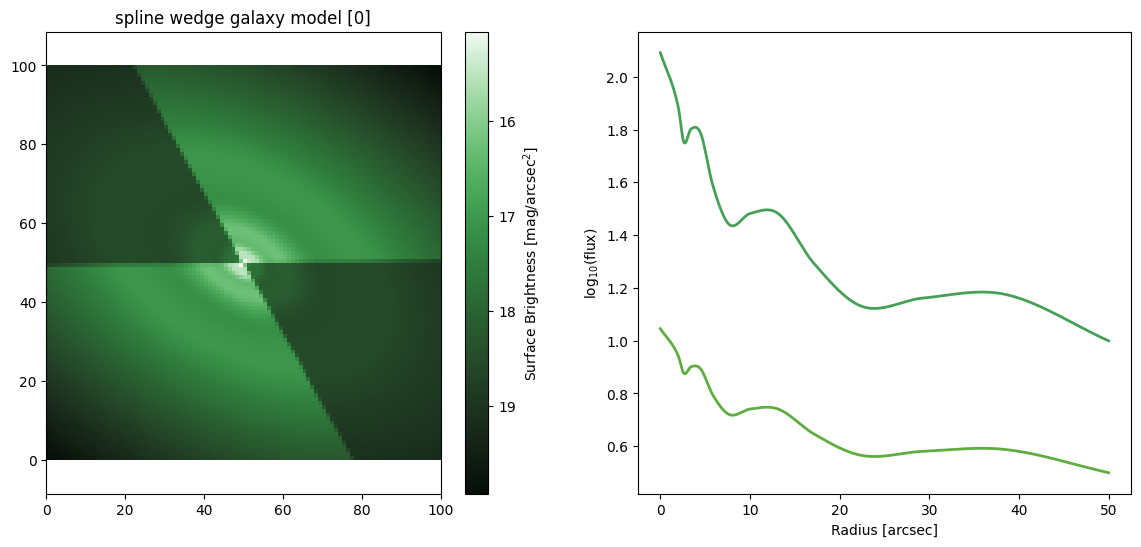

In [35]:
M = ap.models.AstroPhot_Model(
    model_type = "spline wedge galaxy model", 
    symmetric_wedges = True, 
    wedges = 2, 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "I(R)": {"value": np.array([spline_profile, spline_profile*2]), "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.wedge_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

# High Order Warp Models

The models below combine the Warp coordinate transform with radial behaviour transforms: SuperEllipse and Fourier. These higher order models can create higly complex shapes, though their scientific use-case is less clear. They are included for completeness as they may be useful in some specific instances. These models are also included to demonstrate the flexibility in making AstroPhot models, in a future tutorial we will discuss how to make your own model types.

### Spline SuperEllipse Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'C0', 'I(R)')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'C-2', 'log10(flux/arcsec^2)')


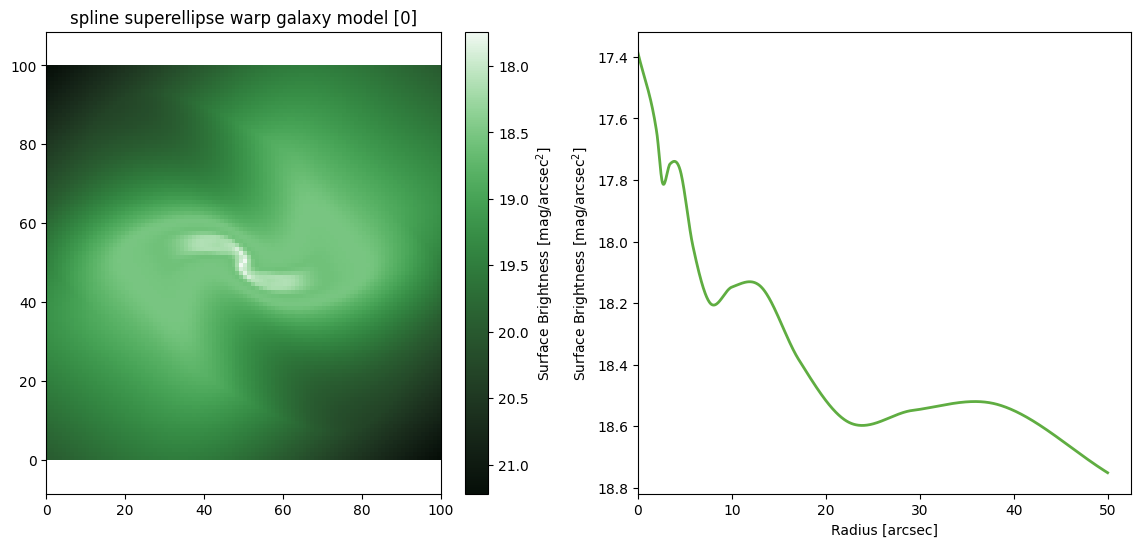

In [36]:
M = ap.models.AstroPhot_Model(
    model_type = "spline superellipse warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "C0": 2, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic SuperEllipse Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'C0', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'C-2', 'none', 'arcsec', 'log10(flux/arcsec^2)')


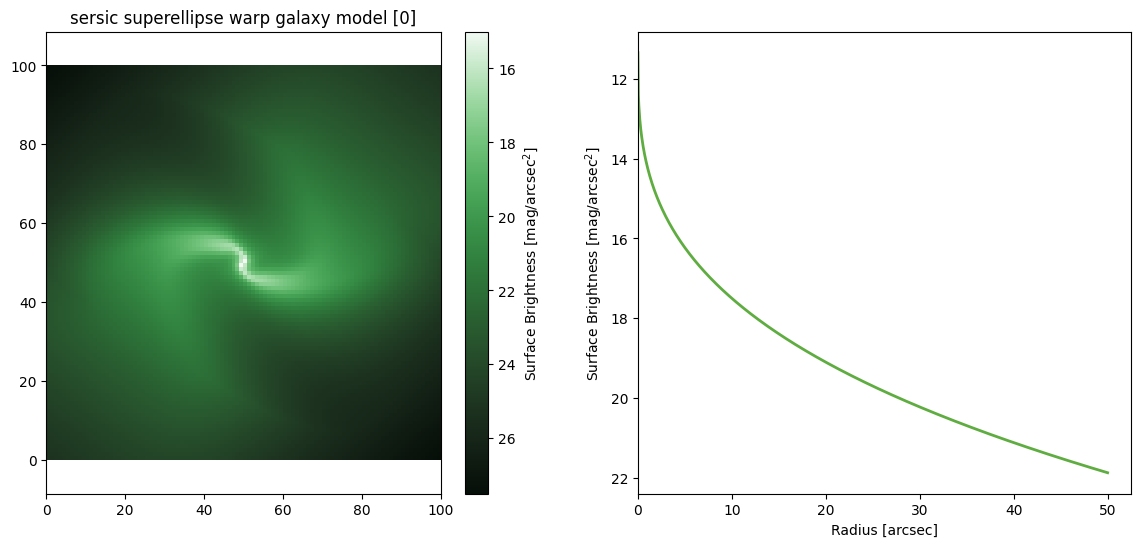

In [37]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic superellipse warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "C0": 2, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential SuperEllipse Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'C0', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'C-2', 'arcsec', 'log10(flux/arcsec^2)')


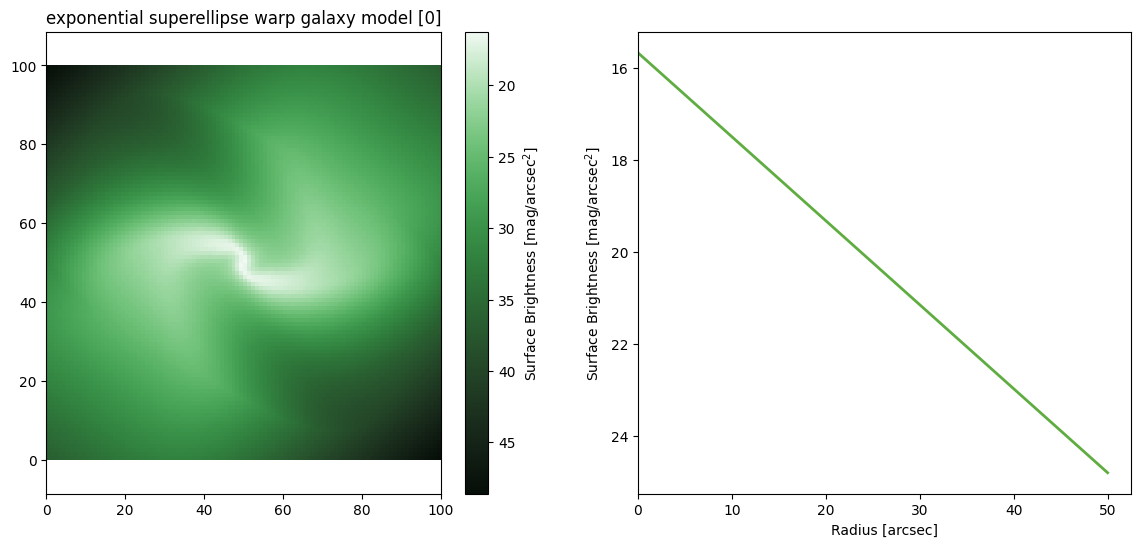

In [38]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential superellipse warp galaxy model",
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "C0": 2, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gaussian SuperEllipse Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'C0', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'C-2', 'arcsec', 'log10(flux)')


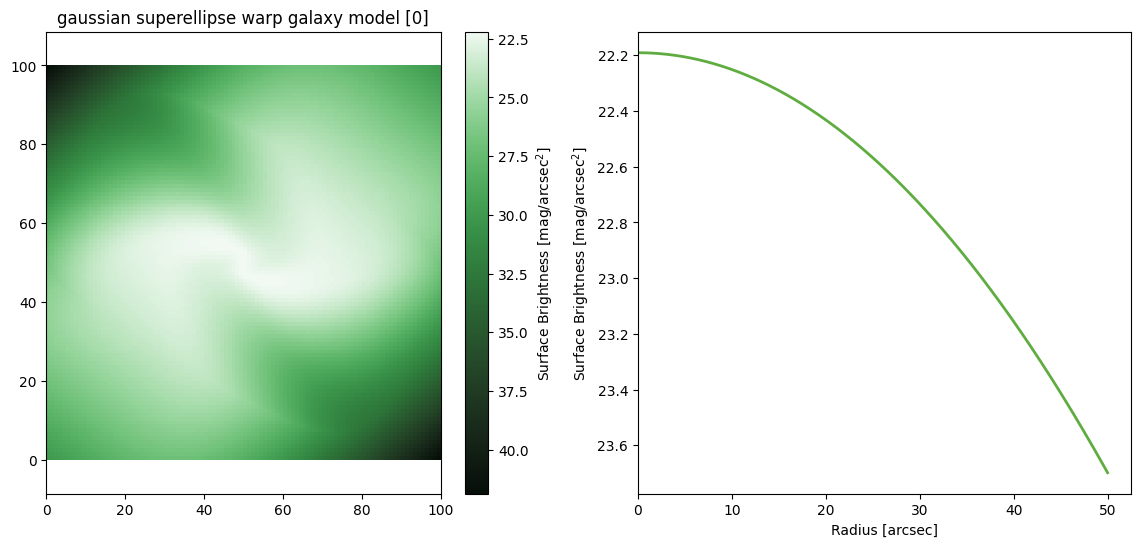

In [39]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian superellipse warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "C0": 2, "sigma": 30, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Spline Fourier Warp

not sure how this abomination would fit a galaxy, but you are welcome to try

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'am', 'phim', 'I(R)')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'none', 'radians', 'log10(flux/arcsec^2)')


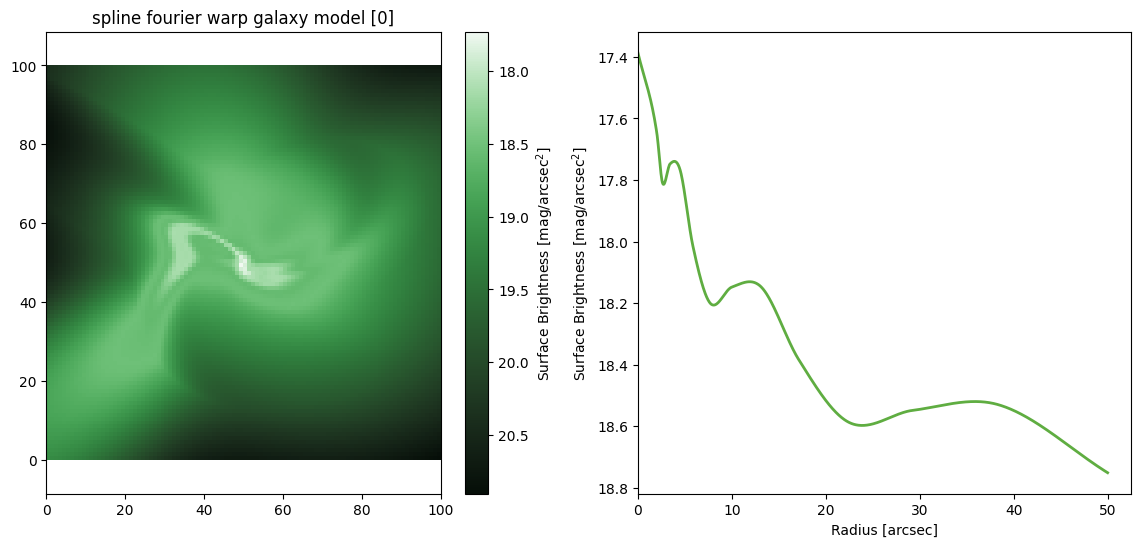

In [40]:
M = ap.models.AstroPhot_Model(
    model_type = "spline fourier warp galaxy model", 
    modes = (1,3,4), 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "am": fourier_am, "phim": fourier_phim, "I(R)": {"value": spline_profile, "prof": NP_prof}}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Sersic Fourier Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'am', 'phim', 'n', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'none', 'radians', 'none', 'arcsec', 'log10(flux/arcsec^2)')


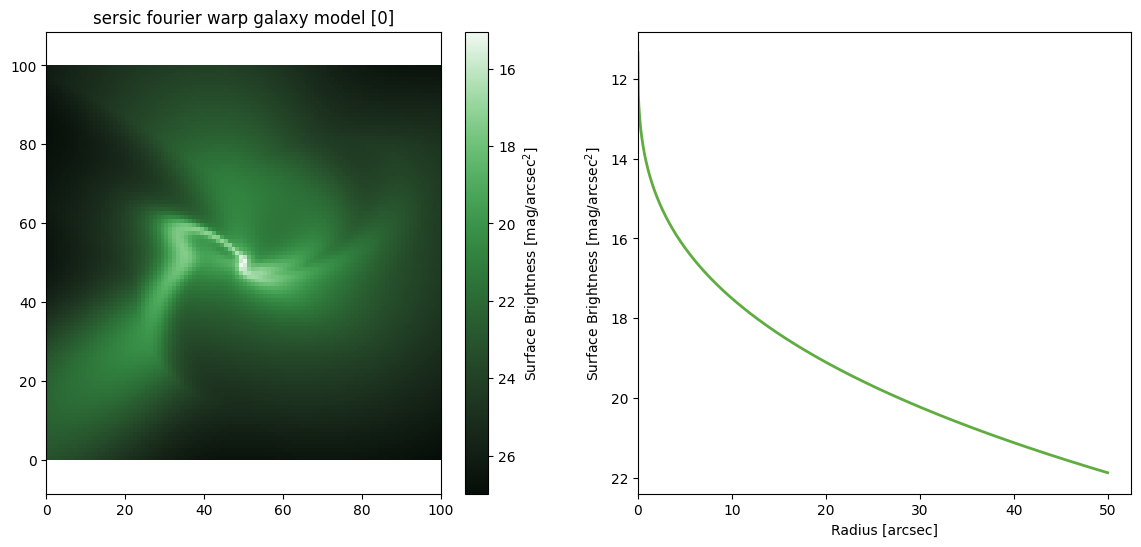

In [41]:
M = ap.models.AstroPhot_Model(
    model_type = "sersic fourier warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "am": fourier_am, "phim": fourier_phim, "n": 3, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Exponential Fourier Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'am', 'phim', 'Re', 'Ie')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'none', 'radians', 'arcsec', 'log10(flux/arcsec^2)')


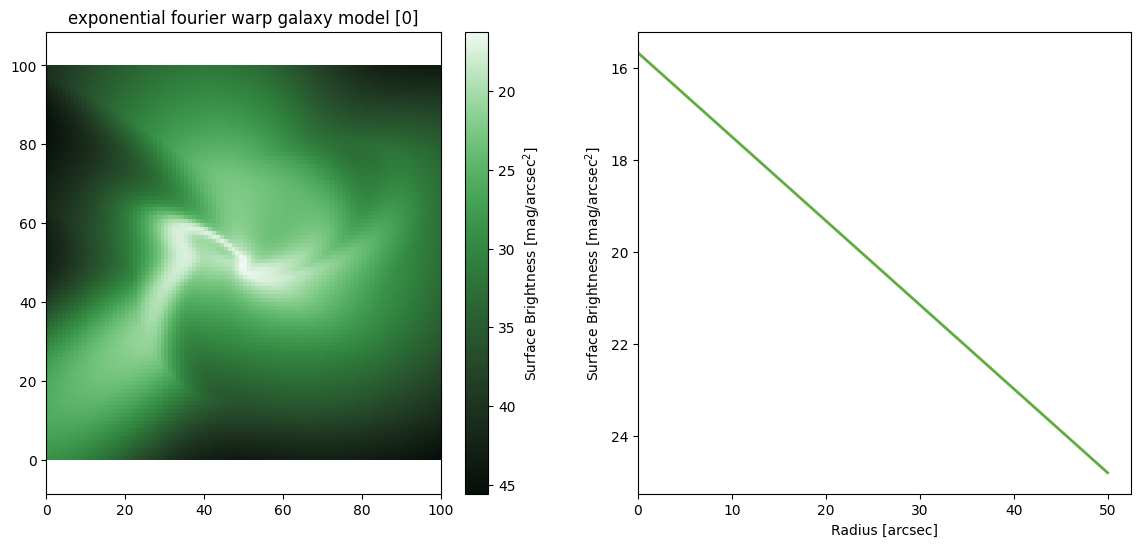

In [42]:
M = ap.models.AstroPhot_Model(
    model_type = "exponential fourier warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "am": fourier_am, "phim": fourier_phim, "Re": 10, "Ie": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()

### Gassian Fourier Warp

('center', 'q', 'PA', 'q(R)', 'PA(R)', 'am', 'phim', 'sigma', 'flux')
('arcsec', 'b/a', 'radians', 'b/a', 'rad', 'none', 'radians', 'arcsec', 'log10(flux)')


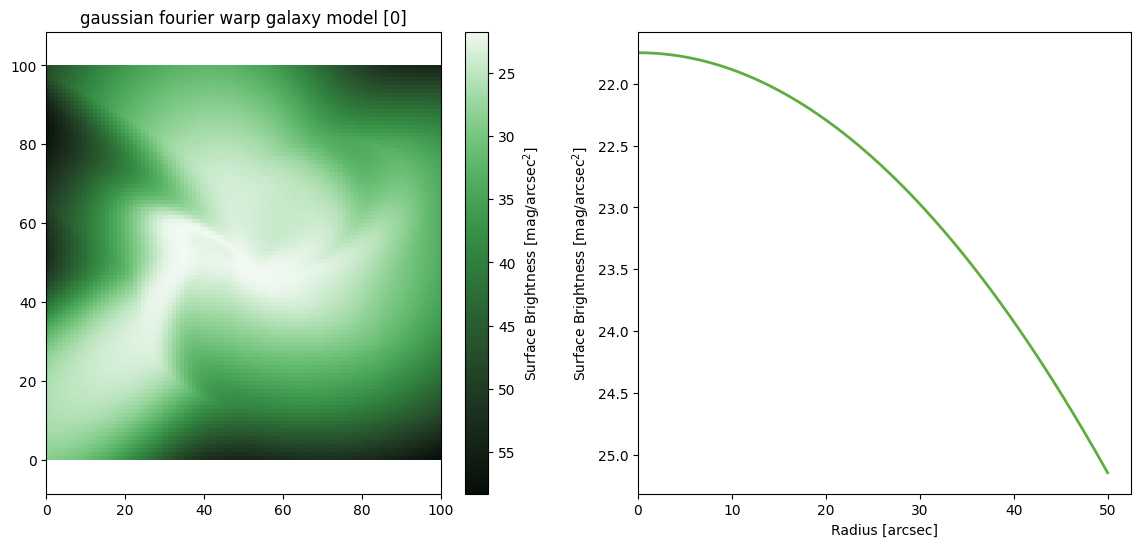

In [43]:
M = ap.models.AstroPhot_Model(
    model_type = "gaussian fourier warp galaxy model", 
    parameters = {"center": [50,50], "q": 0.6, "PA": 60*np.pi/180, "q(R)": warp_q, "PA(R)": warp_pa, "am": fourier_am, "phim": fourier_phim, "sigma": 20, "flux": 1}, 
    target = basic_target
)
print(M.parameter_order)
print(tuple(P.units for P in M.parameters))
M.initialize()

fig, ax = plt.subplots(1,2, figsize = (14,6))
ap.plots.model_image(fig, ax[0], M)
ap.plots.radial_light_profile(fig,ax[1],M)
ax[0].set_title(M.name)
plt.show()